In [2]:
# Libreries
import numpy as np
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, average_precision_score, log_loss, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV

# Config
sns.set_palette('pastel') 
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

- Haremos un modelo predictivo de reviews de clientes (1 - 5 estrellas)
- El objetivo es identificar pedidos con riesgo a obtener baja calificacion (1-2 estrellas) y mandarles una oferta o hacer un envio express automaticamente. 
- De esta forma el cliente calificara mas alto. Las mejores predicciones son las que reducen el churn, mejoran la experiencia del cliente y optimizan la logistica, ya que esto impacta directamente en ingresos y costos
- Otras predicciones podrian ser el tiempo de entrega o customer lifetime value
- Acceder a las features que necesitamos
- Hacer limpieza con las columnas necesarias
- Target encoding en el corss validation

>
- Customers: customer_id, customer_zip_code_prefix
- Geolocation: geolocation_zip_code_prefix, geolocation_lat, geolocation_lng
- Order items: seller_id, order_id, product_id, shipping_limit_date, price, freight_value, order_item_id
- Order payments: order_id, payment_type, payment_value
- Order reviews: order_id, review_score
- Orders dataset: order_id, customer_id, order_purchase_timestamp, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_ delivery_date
- Products dataset: product_id, product_category, product_weight_g, product_lengh_cm, product_height_cm, product_width_cm
- Seller dataset: seller_zip_code_prefix, seller_id
- Product category name trans: Cambiar nombre de portugues a ingles
- Feature engineering: (order_delivered_customer_date - order_purchase_timestamp), (order_delivered_customer_date - order_estimated_delivery_date)


Aprendizajes:
- No conviene hacer un megamerge desde el principio, es mejor ir haciendo merges segun lo necesitemos para el analisis
- Para machine learning con multiples tablas, si debemos hacer un merge entre todas. Primero decidir la target feature, y en base a eso, crear features agregadas (numero de items, precio promedio/total, avg_ticket_cliente, ordenes_totales_cliente)
- Existen tipos de dato utiles para ahorrar memoria, que limitan los bytes de almacenamiento, como int8, que solo usa 8 bits (1 byte). Util cuando sabes que cierta columna no pasa de determinado rango (-128, 127)
- Separar reviews en dos grupos, positivas y negativas, ya que eso es lo que quiero predecir
- Modelos como la regresion logistica, necesitan que la clase positiva sea la clase a predecir, ya que esto cambia como calculan el score
- Es buena idea usar varias metricas con el modelo, no solo una como f1-score, ya que cada una nos da diferente informacion del modelo
- Investigar y pensar muy bien antes de empezar el proyecto, sobre el problema en cuestion, sobre que target quiero predecir y que features necesito para esto, quizas las reviews no fue una buena idea con las features disponibles. Tambien debo tener mas conocimiento en el tema
- Si el target es desbalanceado, debes cambiar el *Threshold* (umbral): Es el límite de probabilidad a partir del cual tu modelo decide si una muestra pertenece a una clase o no. Es buena practica que sea igual al porcentaje de la clase positiva

### Cleaning Tables

In [3]:
# Loading the data and querying just the columns we need
con = duckdb.connect(database='ecommerce.duckdb', read_only=False)
query = """SELECT customer_id,customer_zip_code_prefix FROM read_csv_auto('archivos/olist_customers_dataset.csv')"""
customers = con.execute(query).df()

query = """SELECT geolocation_zip_code_prefix,geolocation_lat,geolocation_lng FROM read_csv_auto('archivos/olist_geolocation_dataset.csv')"""
geolocation = con.execute(query).df()

query = """SELECT seller_id, order_id, product_id, price, freight_value, order_item_id, shipping_limit_date FROM read_csv_auto('archivos/olist_order_items_dataset.csv')"""
order_items = con.execute(query).df()

query = """SELECT order_id, payment_type, payment_value FROM read_csv_auto('archivos/olist_order_payments_dataset.csv')"""
order_payments = con.execute(query).df()

query = """SELECT order_id, review_score FROM read_csv_auto('archivos/olist_order_reviews_dataset.csv')"""
order_reviews = con.execute(query).df()

query = """SELECT order_id, customer_id, order_delivered_carrier_date, order_estimated_delivery_date, order_purchase_timestamp, order_delivered_customer_date  FROM read_csv_auto('archivos/olist_orders_dataset.csv')"""
orders = con.execute(query).df()

query = """SELECT product_id, product_category_name, product_weight_g, product_length_cm, product_height_cm, product_width_cm FROM read_csv_auto('archivos/olist_products_dataset.csv')"""
products = con.execute(query).df()

query = """SELECT seller_zip_code_prefix, seller_id FROM read_csv_auto('archivos/olist_sellers_dataset.csv')"""
sellers = con.execute(query).df()

query = """SELECT * FROM read_csv_auto('archivos/product_category_name_translation.csv')"""
category_translation = con.execute(query).df()


In [4]:
clean_payments = order_payments.groupby('order_id').agg(
    payment_type = ('payment_type', lambda x: x.mode().iloc[0]),
    total_payment = ('payment_value', 'sum')
).reset_index()

In [5]:
# Averaging geolocation by zip code prefix
geolocation_mean = geolocation.groupby('geolocation_zip_code_prefix').agg({'geolocation_lat': 'mean', 'geolocation_lng': 'mean'}).reset_index()
geolocation_mean.columns = ['geolocation_zip_code_prefix', 'geolocation_lat_seller', 'geolocation_lng_seller']

# Translating product category names to English
products.product_category_name.replace(category_translation.set_index('product_category_name')['product_category_name_english'], inplace=True)

# Creating a new dataframe with product volume and dropping the dimensions columns
products_clean = products.copy()
products_clean['product_volume_cm'] = products_clean['product_length_cm'] * products_clean['product_height_cm'] * products_clean['product_width_cm']
products_clean.drop(['product_length_cm', 'product_height_cm', 'product_width_cm'], axis=1, inplace=True)

# Merging items with products to have product category and dimensions
items_full = pd.merge(order_items, products_clean, on='product_id', how='left')
# Merging items with sellers to have seller location
items_full = pd.merge(items_full, sellers, on='seller_id', how='left')
# Merging items with geolocation to have seller lat and lng
items_full = pd.merge(items_full, geolocation_mean, left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')

C:\Users\Danie\AppData\Local\Temp\ipykernel_1141268\3682560361.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  products.product_category_name.replace(category_translation.set_index('product_category_name')['product_category_name_english'], inplace=True)


In [6]:
# Grouping items by order_id to have a single row per order, aplying aggregations
items_full = items_full.groupby('order_id').agg(
                            shipping_limit_date=('shipping_limit_date', 'first'),
                            item_price_mean=('price', 'mean'),
                            freight_value_mean=('freight_value', 'mean'),
                            n_items=('order_item_id', 'last'),
                            unique_items=('product_id', 'nunique'),
                            unique_sellers=('seller_id', 'nunique'),
                            seller_lat=('geolocation_lat_seller', 'first'),
                            seller_lng=('geolocation_lng_seller', 'first'),
                            product_category=('product_category_name', 'first'),
                            product_weight_g_sum=('product_weight_g', 'sum'),
                            product_weight_g_mean=('product_weight_g', 'mean'),
                            product_volume_cm_sum=('product_volume_cm', 'sum'),
                            product_volume_cm_mean=('product_volume_cm', 'mean')).reset_index()

In [7]:
# Grouping reviews by order_id to have a single review score per order (mean)
order_reviews_mean = order_reviews.groupby('order_id')['review_score'].agg(lambda x: x.mean().round()).reset_index()

# Merging all the dataframes to create a single one
orders_full = pd.merge(order_reviews_mean, orders, on='order_id', how='left')
orders_full = pd.merge(orders_full, items_full, on='order_id', how='left')
orders_full = pd.merge(orders_full, clean_payments, on='order_id', how='left')
orders_full = pd.merge(orders_full, customers, on='customer_id', how='left')
geolocation_mean.columns = ['geolocation_zip_code_prefix', 'customer_lat', 'customer_lng']
orders_full = pd.merge(orders_full, geolocation_mean, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')

# Cleaning dates, creating columns for delay_days, delivery day of week, delivery month and shipping delay days
orders_full['delivery_delay_days'] = (orders_full['order_delivered_customer_date'] - orders_full['order_estimated_delivery_date']).dt.days
orders_full['purchase_month'] = orders_full['order_purchase_timestamp'].dt.month
orders_full['shipping_delay_days'] = (orders_full['order_delivered_carrier_date'] - orders_full['shipping_limit_date']).dt.days

# Creating geolocation differences
orders_full['lat_diff'] = orders_full['seller_lat'] - orders_full['customer_lat']
orders_full['lng_diff'] = orders_full['seller_lng'] - orders_full['customer_lng']
orders_full['geo_diff'] = np.sqrt(orders_full['lat_diff']**2 + orders_full['lng_diff']**2)

# Deleting unnecessary columns
orders_full.drop(['geolocation_zip_code_prefix', 'customer_zip_code_prefix', 'order_id', 'customer_id',
                  'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'shipping_limit_date'], 
                 axis=1, inplace=True)

In [8]:
orders_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98673 entries, 0 to 98672
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   review_score              98673 non-null  float64       
 1   order_purchase_timestamp  98673 non-null  datetime64[us]
 2   item_price_mean           97917 non-null  float64       
 3   freight_value_mean        97917 non-null  float64       
 4   n_items                   97917 non-null  float64       
 5   unique_items              97917 non-null  float64       
 6   unique_sellers            97917 non-null  float64       
 7   seller_lat                97702 non-null  float64       
 8   seller_lng                97702 non-null  float64       
 9   product_category          96538 non-null  object        
 10  product_weight_g_sum      97917 non-null  Int64         
 11  product_weight_g_mean     97901 non-null  Float64       
 12  product_volume_cm_

In [9]:
# Reordering columns
orders_full = orders_full[['review_score', 'item_price_mean', 'freight_value_mean', 'total_payment', 'n_items',
                           'unique_items', 'unique_sellers','payment_type', 'product_category', 'product_weight_g_sum',
                           'product_weight_g_mean', 'product_volume_cm_sum', 'product_volume_cm_mean', 'delivery_delay_days',
                           'purchase_month', 'shipping_delay_days', 'seller_lat', 'seller_lng', 'customer_lat',
                           'customer_lng', 'lat_diff', 'lng_diff', 'geo_diff']]

# Selecting categorical and numerical features
categorical_features = ['payment_type', 'product_category']
numerical_features = orders_full.select_dtypes(include=['int64', 'float64', 'Float64','int32']).columns.tolist()
numerical_features.remove('review_score')

# Imputing missing values for analysis
orders_full_imputed = orders_full.copy()
for col in numerical_features:
    median = orders_full_imputed[col].median()
    orders_full_imputed[col].fillna(median, inplace=True)

for col in categorical_features:
    mode = orders_full_imputed[col].mode()[0]
    orders_full_imputed[col].fillna(mode, inplace=True)

# Selecting the right value types
orders_full_imputed.n_items = orders_full_imputed.n_items.astype('int8')
orders_full_imputed.unique_items = orders_full_imputed.unique_items.astype('int8')
orders_full_imputed.review_score = orders_full_imputed.review_score.astype('int8')
orders_full_imputed.unique_sellers = orders_full_imputed.unique_sellers.astype('int8')
orders_full_imputed.purchase_month = orders_full_imputed.purchase_month.astype('int8')
orders_full_imputed.shipping_delay_days = orders_full_imputed.shipping_delay_days.astype('int8')
orders_full_imputed.delivery_delay_days = orders_full_imputed.delivery_delay_days.astype('int16')

C:\Users\Danie\AppData\Local\Temp\ipykernel_1141268\1689168259.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  orders_full_imputed[col].fillna(median, inplace=True)
C:\Users\Danie\AppData\Local\Temp\ipykernel_1141268\1689168259.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a cop

# Exploratory Data Analysis

In [10]:
orders_full_imputed.to_csv('orders_full_imputed.csv', index=False)

In [33]:
orders_full_imputed

,review_score,item_price_mean,freight_value_mean,total_payment,n_items,unique_items,unique_sellers,payment_type,product_category,product_weight_g_sum,product_weight_g_mean,product_volume_cm_sum,product_volume_cm_mean,delivery_delay_days,purchase_month,shipping_delay_days,seller_lat,seller_lng,customer_lat,customer_lng,lat_diff,lng_diff,geo_diff,delivery_bin,shipping_delivery_bin,items_bin
0,5,58.90,13.29,72.19,1,1,1,credit_card,cool_stuff,650,650.0,3528,3528.0,-9,9,0,-22.496953,-44.127492,-21.762775,-41.309633,-0.734177,-2.817859,2.911932,NaN,OnTime,One Item
1,4,239.90,19.93,259.83,1,1,1,credit_card,pet_shop,30000,30000.0,60000,60000.0,-3,4,1,-23.565096,-46.518565,-20.220527,-50.903424,-3.344569,4.384859,5.514810,OnTime,1-3d,One Item
2,5,199.00,17.87,216.87,1,1,1,credit_card,furniture_decor,3050,3050.0,14157,14157.0,-14,1,-3,-22.262584,-46.171124,-19.870305,-44.593326,-2.392279,-1.577798,2.865737,NaN,NaN,One Item
3,4,12.99,12.79,25.78,1,1,1,credit_card,perfumery,200,200.0,2400,2400.0,-6,8,-5,-20.553624,-47.387359,-23.089925,-46.611654,2.536302,-0.775705,2.652271,NaN,NaN,One Item
4,5,199.90,18.14,218.04,1,1,1,credit_card,garden_tools,3750,3750.0,42000,42000.0,-16,2,2,-22.929384,-53.135873,-23.243402,-46.827614,0.314018,-6.308258,6.316069,NaN,1-3d,One Item
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98668,5,299.99,43.41,343.40,1,1,1,boleto,housewares,10150,10150.0,53400,53400.0,-8,4,-7,-26.912574,-48.673980,-2.497993,-44.297761,-24.414581,-4.376219,24.803690,NaN,NaN,One Item
98669,5,350.00,36.53,386.53,1,1,1,boleto,computers_accessories,8950,8950.0,44460,44460.0,-9,7,-3,-23.535864,-46.642819,-25.566904,-49.309115,2.031041,2.666296,3.351755,NaN,NaN,One Item
98670,5,99.90,16.95,116.85,1,1,1,credit_card,sports_leisure,967,967.0,9576,9576.0,-13,10,-5,-25.469955,-49.289821,-23.597794,-46.643923,-1.872161,-2.645898,3.241260,NaN,NaN,One Item
98671,5,55.99,8.72,64.71,1,1,1,credit_card,computers_accessories,100,100.0,8000,8000.0,-9,8,-6,-23.635530,-46.694031,-23.040252,-46.979782,-0.595278,0.285751,0.660310,NaN,NaN,One Item


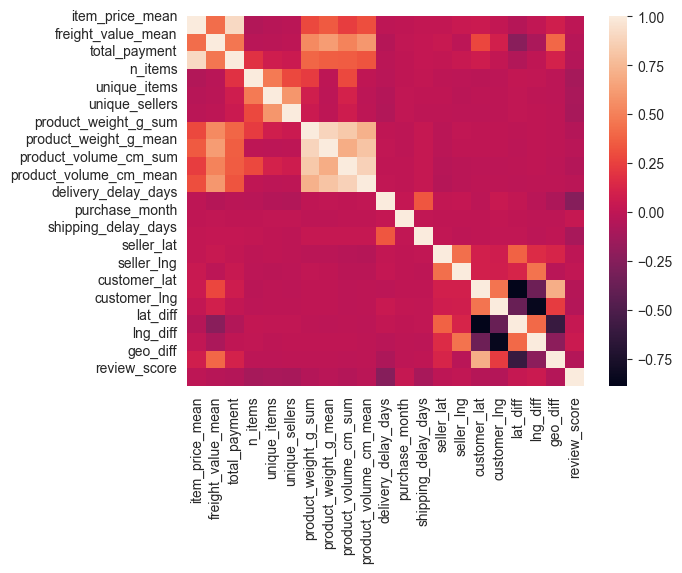

In [12]:
numerical_features.append('review_score')
correlations = orders_full_imputed[numerical_features].corr()
sns.heatmap(data=correlations)
plt.yticks(ticks=range(len(correlations.columns)), labels=correlations.columns, rotation=0)
plt.show()

In [13]:
orders_full_imputed[numerical_features].corr(method="spearman")["review_score"].sort_values(ascending=False)

review_score              1.000000
lng_diff                  0.048138
purchase_month            0.032021
lat_diff                  0.024288
seller_lng                0.006164
item_price_mean          -0.003020
product_weight_g_mean    -0.015101
product_volume_cm_mean   -0.016476
seller_lat               -0.016977
product_weight_g_sum     -0.033065
product_volume_cm_sum    -0.035110
customer_lat             -0.036793
total_payment            -0.042605
customer_lng             -0.045736
freight_value_mean       -0.049466
geo_diff                 -0.062420
shipping_delay_days      -0.065421
unique_items             -0.082494
unique_sellers           -0.088178
n_items                  -0.098689
delivery_delay_days      -0.172532
Name: review_score, dtype: float64

In [14]:
from sklearn.feature_selection import mutual_info_classif
X = orders_full_imputed.drop("review_score", axis=1).select_dtypes(include=["number"])
y = orders_full_imputed["review_score"]
mi = mutual_info_classif(X, y, discrete_features="auto")
pd.Series(mi, index=X.columns).sort_values(ascending=False)[:10]

delivery_delay_days       0.075492
seller_lng                0.028602
seller_lat                0.024451
product_volume_cm_sum     0.020541
unique_sellers            0.019256
product_volume_cm_mean    0.018139
freight_value_mean        0.015949
customer_lat              0.014314
item_price_mean           0.013916
customer_lng              0.013741
dtype: float64

### Categorical Features

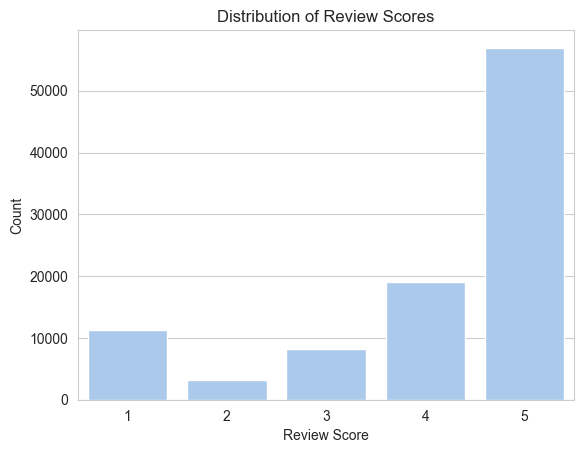

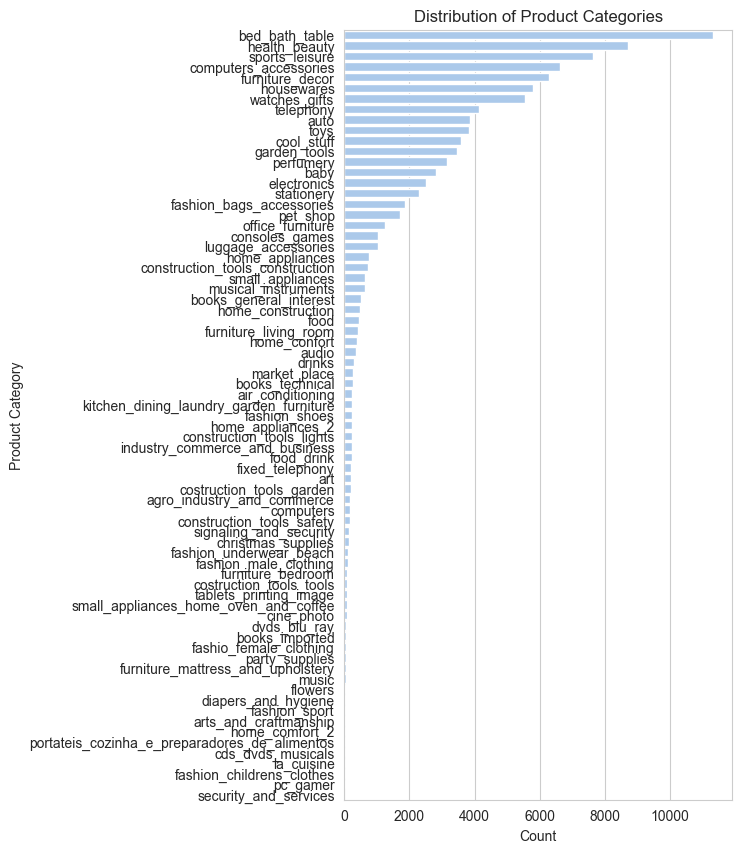

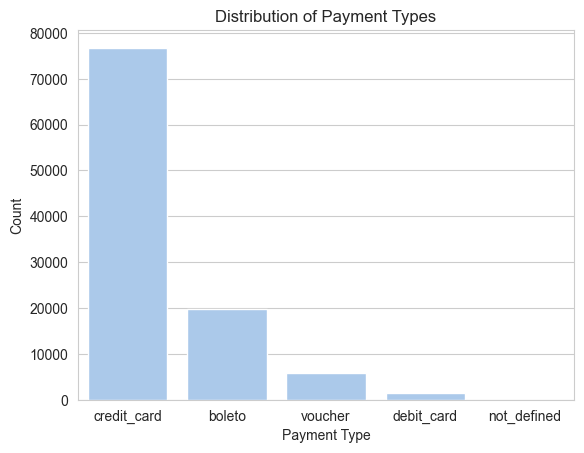

In [15]:
sns.countplot(x='review_score', data=orders_full_imputed)
plt.title('Distribution of Review Scores')
plt.xlabel('Review Score')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(5,10))
sns.countplot(y='product_category', data=orders_full_imputed, order=orders_full_imputed['product_category'].value_counts().index)
plt.title('Distribution of Product Categories')
plt.ylabel('Product Category')
plt.xlabel('Count')
plt.show()

sns.countplot(x='payment_type', data=order_payments)
plt.title('Distribution of Payment Types')
plt.xlabel('Payment Type')
plt.ylabel('Count')
plt.show()

### Observations
- The dataset is unbalanced; there are many more positive reviews than negative ones. 
- A 57.7% of reviews are 5 stars, and only a 14.6% are 1 or 2 stars.
- The most purchased categories are: Bed Bath Table, Health Beaty, Sport Leisure, Computer Accesories
- The most used payment method is 'Credit Card'

In [16]:
# Avarage reviews of payment 
orders_full_imputed.groupby('payment_type')['review_score'].agg(['mean','count']).sort_values(by='mean').drop('not_defined')

,mean,count
payment_type,,
voucher,3.959980,1974
boleto,4.086728,19636
credit_card,4.088180,75539
debit_card,4.169625,1521


### Categories with the worst reviews

In [17]:
pd.set_option('display.max_rows', 10)
orders_full_imputed.groupby('product_category')['review_score'].agg(['mean','count']).sort_values(by='mean')[:10]

,mean,count
product_category,,
security_and_services,2.500000,2
pc_gamer,3.428571,7
portateis_cozinha_e_preparadores_de_alimentos,3.428571,14
office_furniture,3.621514,1255
fashion_male_clothing,3.702703,111
fashio_female_clothing,3.717949,39
diapers_and_hygiene,3.740741,27
furniture_mattress_and_upholstery,3.815789,38
bed_bath_table,3.826811,11346


Observations:
- The avarage of reviews are 4.08
- Orders made with voucher payment have an avarage review of 3.95 (-3.29%)
- Security and services with only 2 records have the worst avarage review, with 2.5 (-63.2%)
- Office Furniture category with 1255 records have an avarage review of 3.62 (-12.7%)
- Bed bath tables category with 11346 records have an avarage review of 3.82 (-6.8%)

### Numerical features

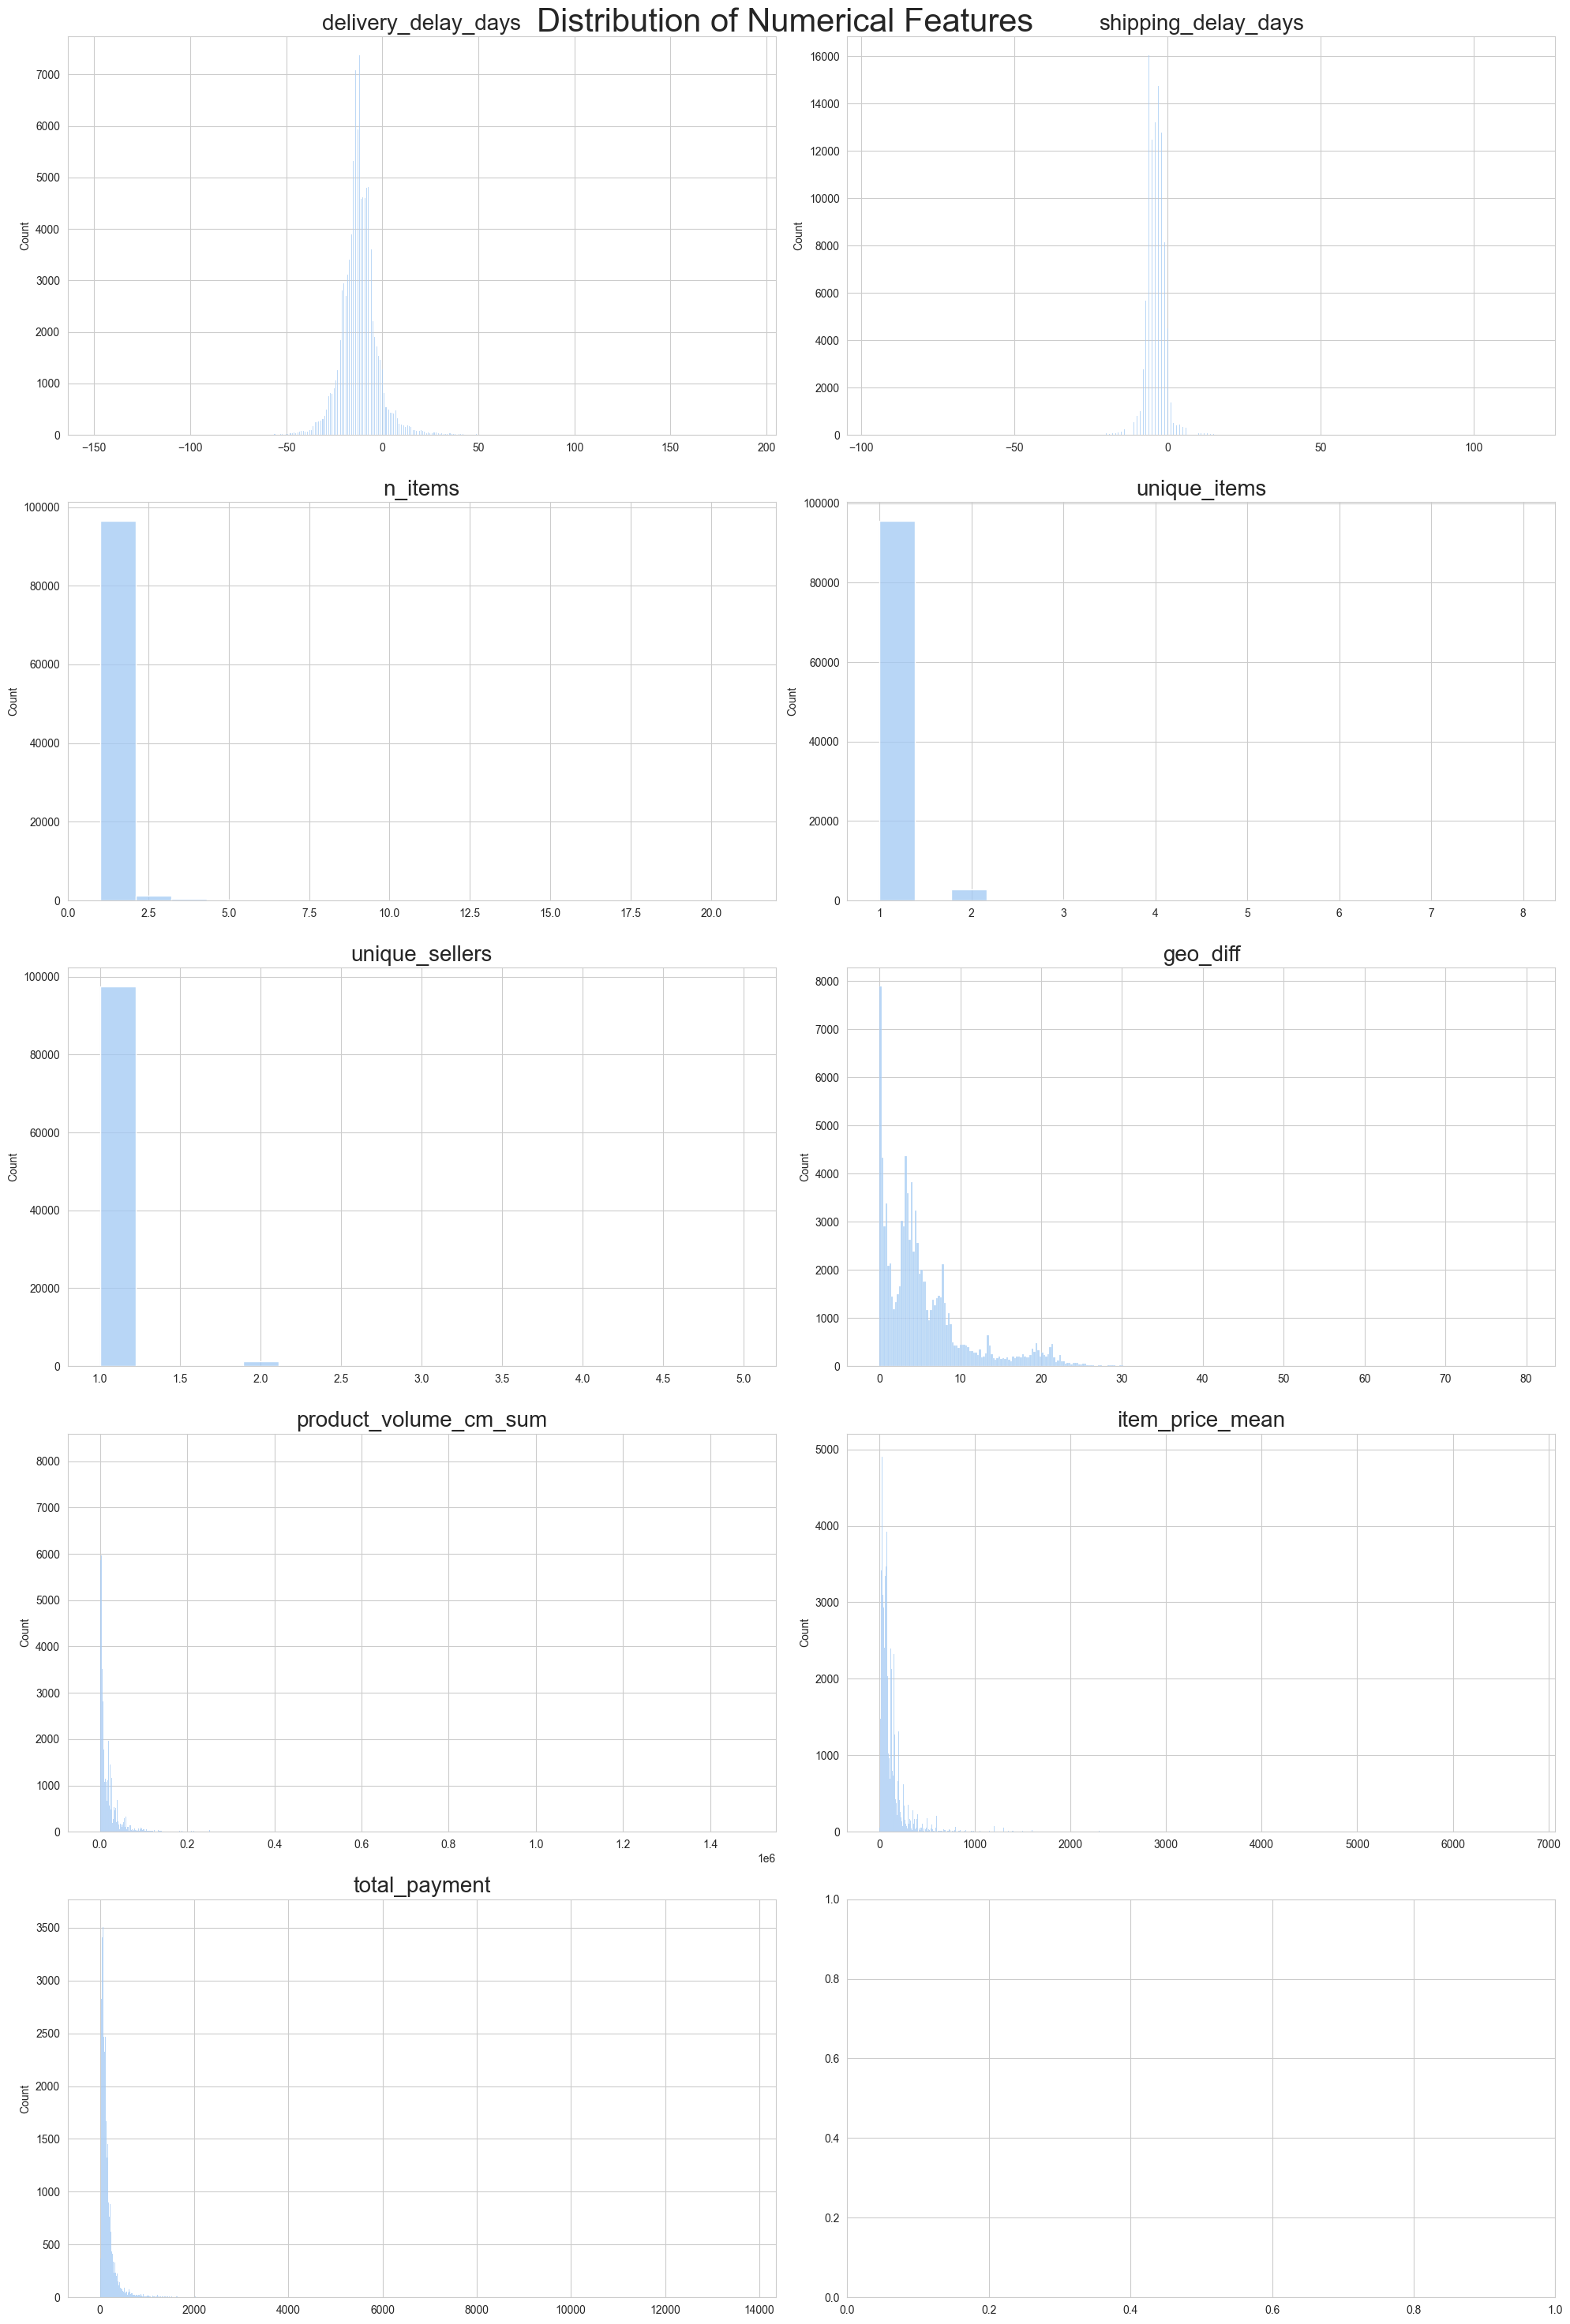

In [18]:
features = ['delivery_delay_days','shipping_delay_days','n_items', 'unique_items', 'unique_sellers', 'geo_diff',
            'product_volume_cm_sum','item_price_mean', 'total_payment']
fig, axes = plt.subplots(5,2, figsize=(20,30))
axes = axes.flatten()
for i, col in enumerate(features):
    sns.histplot(orders_full_imputed[col], ax=axes[i])
    axes[i].set_title(col, fontsize=20)
    axes[i].set_xlabel('')
fig.suptitle('Distribution of Numerical Features', fontsize=30)
plt.tight_layout()
plt.show()


### Observations
- Normal distributed features: Delivery Delay Days, Shipping Delay Days
- Distribution skewed to the left: N Items, Unique Items, Unique Sellers, Geo Diff, Product Volume Cm Sum, Item Price Mean, Total Payment
- Most orders are delivered on time, with an average of 12 days' notice.
- 6.46% of orders are delivered late (> 1 day delay)
- Most orders are delivered on time to the shipping company, with an avarage of 4 days' notice.
- 4.44% of orders are delivered late to the sipping company (> 1 day delay)
- On average, an order has 1.14 items
- On avarage, an order has a geolocation difference of 5.56
- On avarage, an order has a product volume of 17291 cm
- On avarage, an order has a item price mean of 125.38 BRL (23.58 USD)
- On avarage, an order has a total payment of 160.72 BRL (30.19 USD)

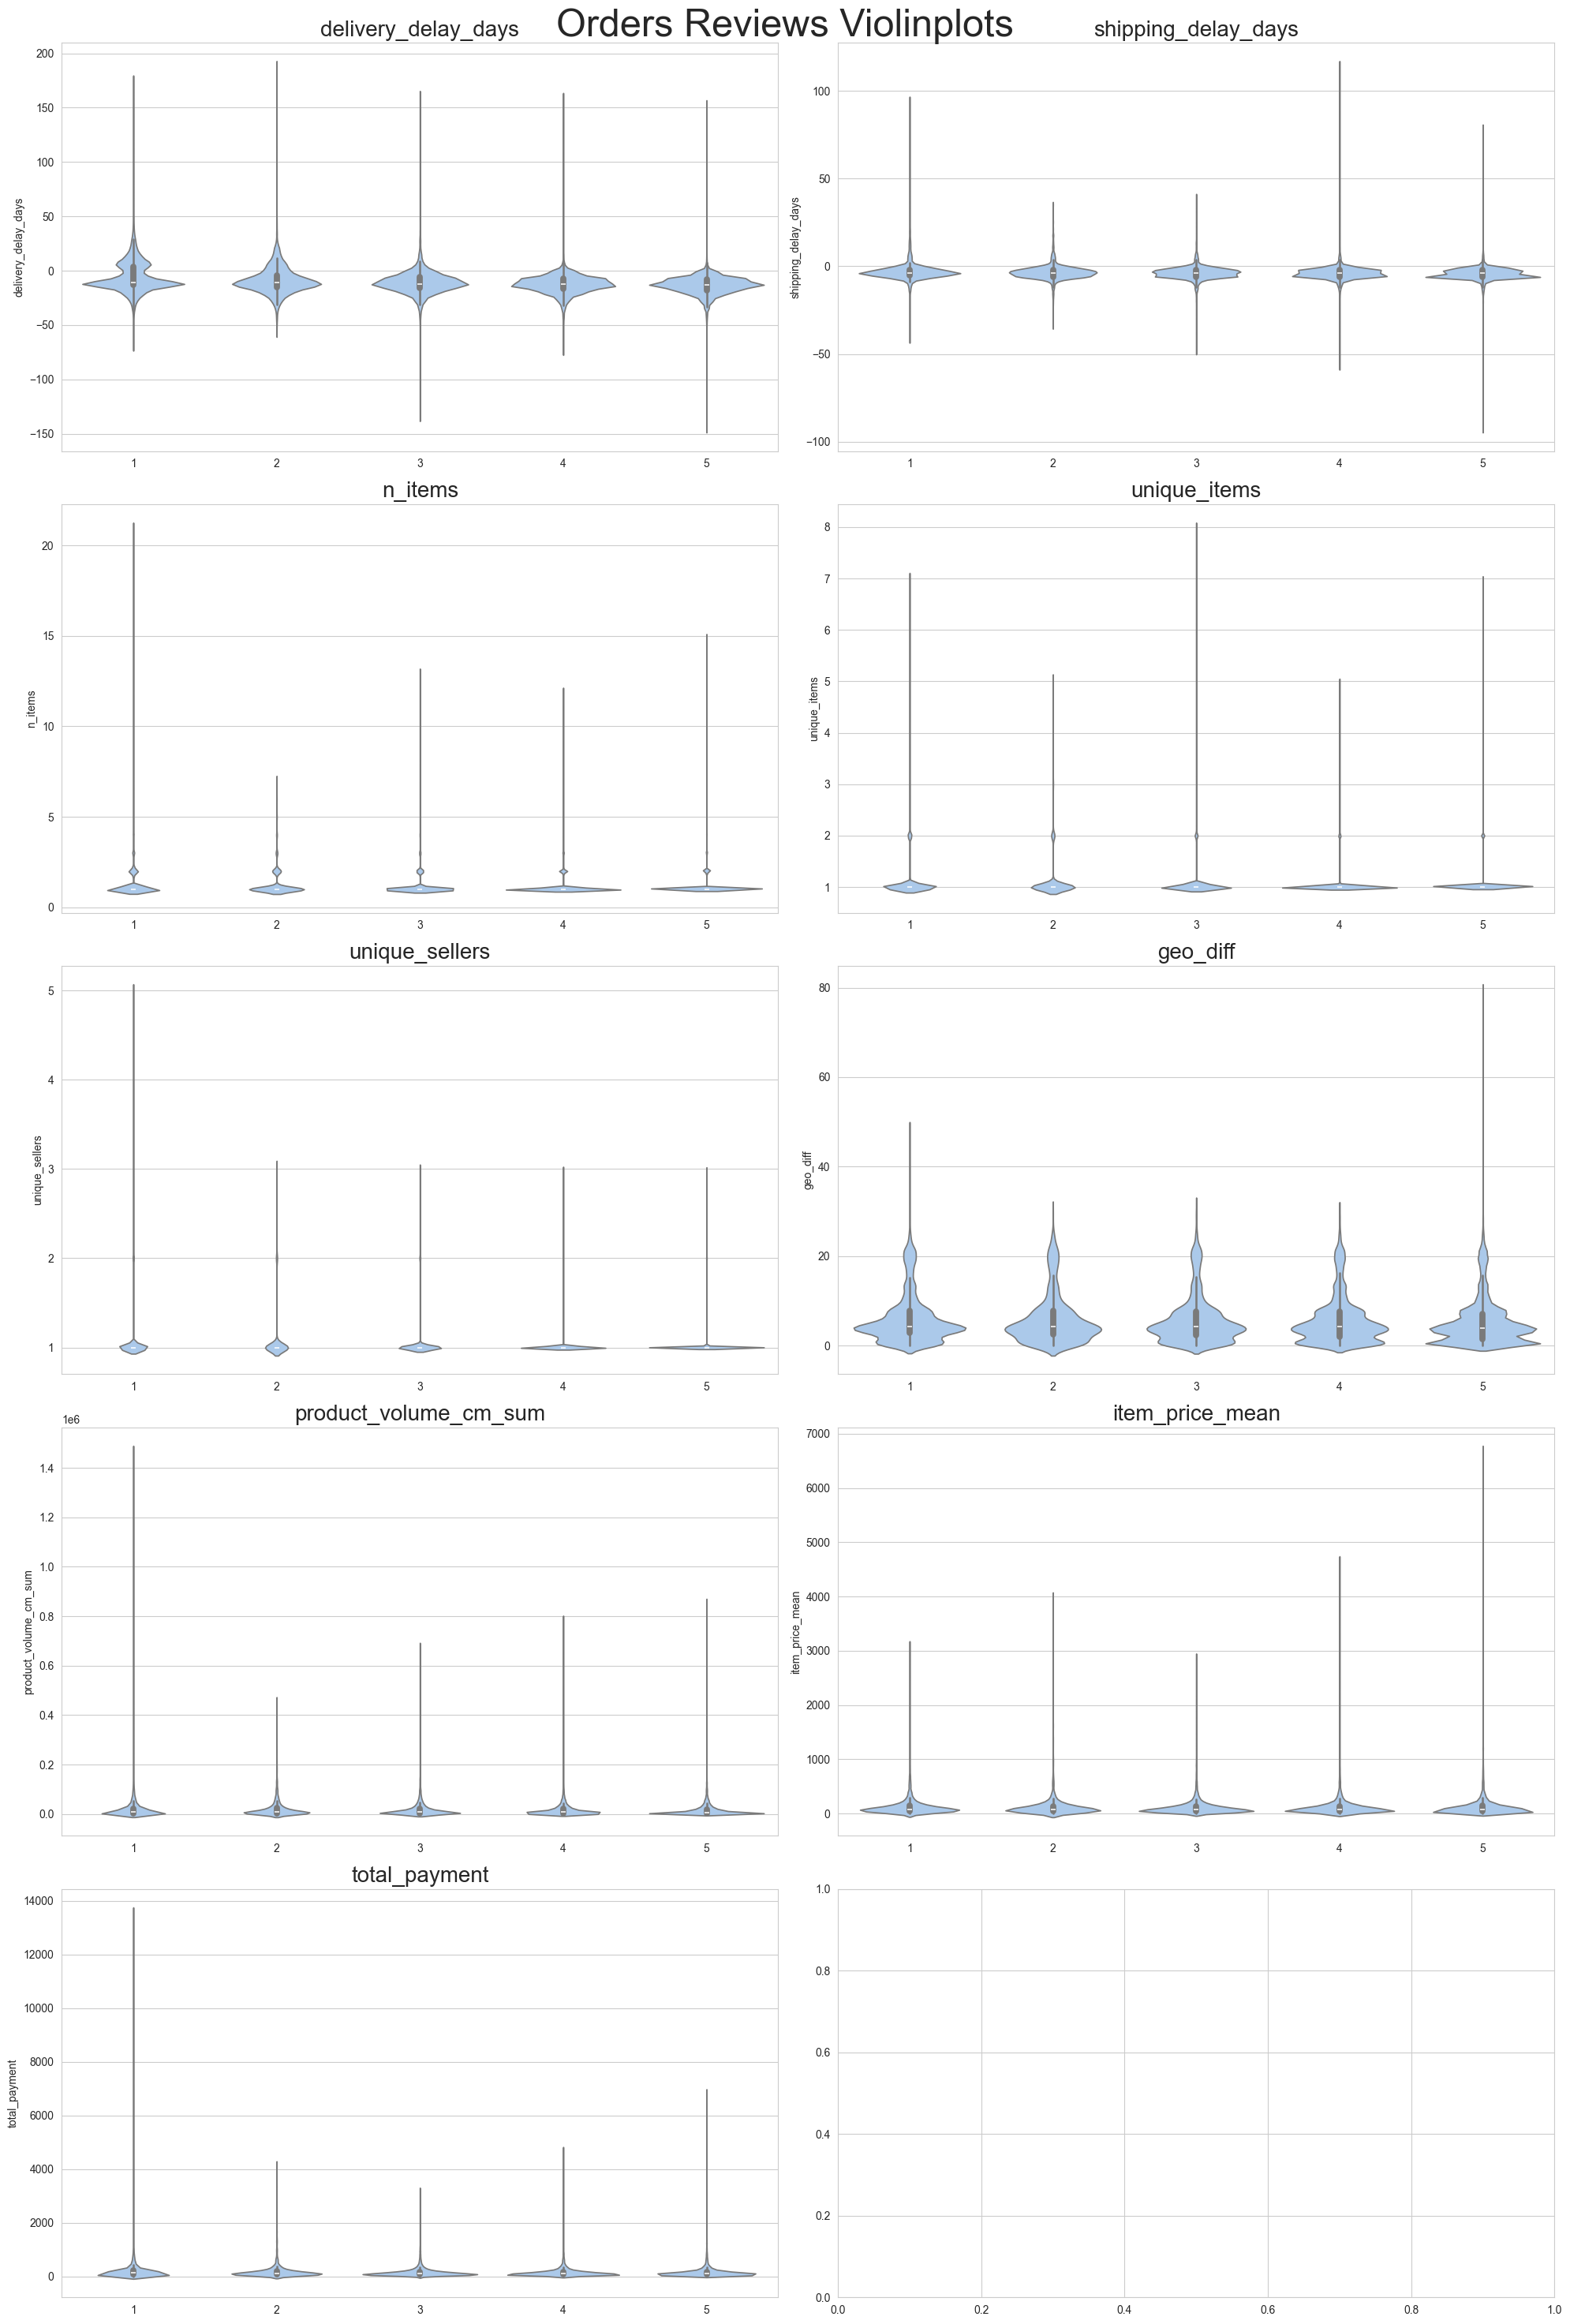

In [19]:
fig, axes = plt.subplots(5,2, figsize=(20,30))
axes = axes.flatten()
for i, col in enumerate(features):
    sns.violinplot(x=orders_full_imputed['review_score'], y=orders_full_imputed[col], ax=axes[i])
    axes[i].set_title(col, fontsize=20)
    axes[i].set_xlabel('')
fig.suptitle('Orders Reviews Violinplots', fontsize=35)
plt.tight_layout()
plt.show()

In [20]:
orders_full_imputed["delivery_bin"] = pd.cut(orders_full_imputed["delivery_delay_days"], bins=[-5,0,3,7,30], labels=["OnTime","1-3d","4-7d","+7d"])
orders_full_imputed.groupby("delivery_bin")["review_score"].mean()

C:\Users\Danie\AppData\Local\Temp\ipykernel_1141268\3664157489.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  orders_full_imputed.groupby("delivery_bin")["review_score"].mean()


delivery_bin
OnTime    4.120183
1-3d      3.291037
4-7d      2.105835
+7d       1.649409
Name: review_score, dtype: float64

<Axes: xlabel='delivery_bin', ylabel='Count'>

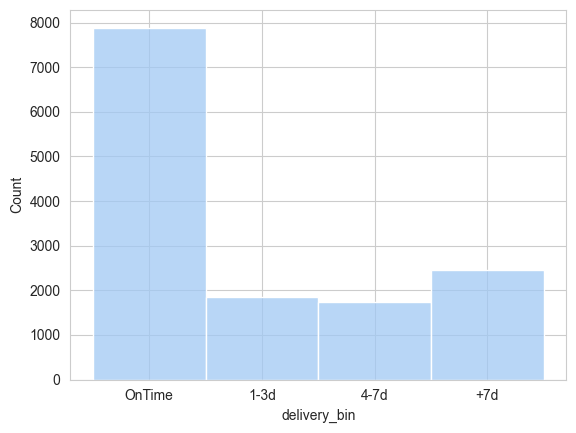

In [21]:
sns.histplot(orders_full_imputed.delivery_bin)

Observations:
- Orders delivered on time have an avarage review of 4.12
- Orders delivered with 1-3 days of delay have an avarage review of 3.29 (-20.14%)
- Orders delivered with more than 7 days of delay have an avarage review of 1.64 (-60.19%)

In [22]:
orders_full_imputed["shipping_delivery_bin"] = pd.cut(orders_full_imputed["shipping_delay_days"], bins=[-3,0,3,7,30], labels=["OnTime","1-3d","4-7d","+7d"])
orders_full_imputed.groupby("shipping_delivery_bin")["review_score"].mean()

C:\Users\Danie\AppData\Local\Temp\ipykernel_1141268\2074009390.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  orders_full_imputed.groupby("shipping_delivery_bin")["review_score"].mean()


shipping_delivery_bin
OnTime    4.099843
1-3d      3.756388
4-7d      3.425766
+7d       2.572360
Name: review_score, dtype: float64

<Axes: xlabel='shipping_delivery_bin', ylabel='Count'>

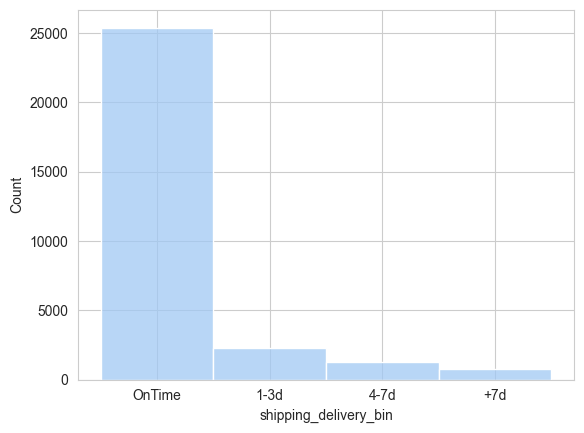

In [23]:
sns.histplot(orders_full_imputed.shipping_delivery_bin)

### Observations
- Orders delivered on time to the shipping company have an avarage review of 4.10
- Orders delivered with 1-3 days of delay to the shipping company have an avarage review of 3.76 (-8.29%)
- Orders delivered with +7 days of delay to the shipping company hava an avarage review of 2.57 (-37.31%)

In [24]:
orders_full_imputed["items_bin"] = pd.cut(orders_full_imputed["n_items"], bins=[0,1,2,3,15], labels=["One Item","Two Items","Three Items",">3 Items"])
orders_full_imputed.groupby("items_bin")["review_score"].mean()

C:\Users\Danie\AppData\Local\Temp\ipykernel_1141268\183730469.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  orders_full_imputed.groupby("items_bin")["review_score"].mean()


items_bin
One Item       4.139409
Two Items      3.653226
Three Items    3.507692
>3 Items       3.321730
Name: review_score, dtype: float64

<Axes: xlabel='items_bin', ylabel='Count'>

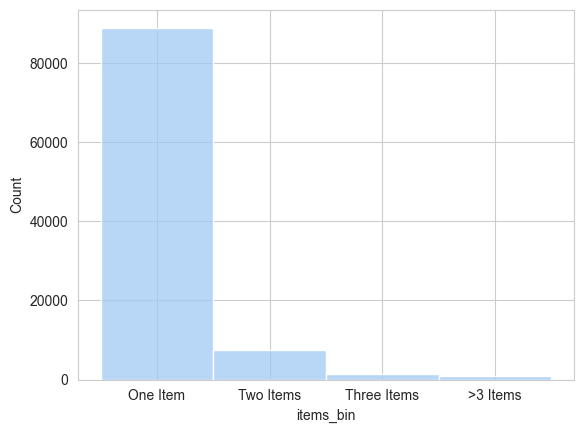

In [25]:
sns.histplot(orders_full_imputed.items_bin)

### Observations
- Orders with one item have an avarage review of 4.13
- Orders with two items have an avarage review of 3.65 (-11.62%)
- Orders with more than 3 items have an avarage review of 3.32 (-19.61%)

In [26]:
# a numero chico, b numero grande
def dif_pct(a,b):
    return (a * 100)/b - 100
dif_pct(3.32,4.13)

-19.61259079903148

In [27]:
# Creating a binary dataframe for predictions
orders_binary = orders_full.copy()
orders_binary["negative_review"] = orders_binary["review_score"].apply(lambda x: 0 if x > 2 else 1)

In [28]:
# Spliting X and y
# Droping delivery_delay_days to avoid target leakage
X = orders_binary.drop(['review_score','delivery_delay_days','negative_review'],axis=1)
y = orders_binary.negative_review
y = y.astype('int8')

# Train/test/val split
train_X, X_temp, train_y, y_temp = train_test_split(X, y, random_state=0, train_size=0.8, test_size=0.2)
val_X, test_X, val_y, test_y = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

# Separating features to preprocess
int8_features = ['n_items', 'unique_items', 'unique_sellers', 'purchase_month', 'shipping_delay_days']
numerical_features = [x for x in X.columns if x not in categorical_features]

In [29]:
# Logistic Regression

int_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('to_int', FunctionTransformer(lambda x: x.astype('int8')))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

payment_type_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

category_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target_enc', TargetEncoder(smoothing=True))
])

preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('pay', payment_type_transformer, ['payment_type']),
        ('cat', category_transformer, ['product_category']),
        ('int', int_transformer, int8_features)
    ])

pipeline = Pipeline(steps=([('preprocessor', preprocessor),
                           ('model', LogisticRegression(max_iter=1000,n_jobs=-1))]))

# Fitting, predictions and probs
pipeline.fit(train_X, train_y)
val_predictions = pipeline.predict(val_X)
probs = pipeline.predict_proba(val_X)[:,1]

# Scoring
print('Logistic Regression Score')
f1 = f1_score(val_y, val_predictions)
print(f'F1 Score: {f1}')
precision = precision_score(val_y, val_predictions)
print(f'Precision {precision}')
recall = recall_score(val_y, val_predictions)
print(f'Recall {recall}')
ll = log_loss(val_y, probs)
print(f'Log Loss: {ll}')

Logistic Regression Score
F1 Score: 0.05859375
Precision 0.4838709677419355
Recall 0.031185031185031187
Log Loss: 0.40517202322004003


In [30]:
test_predictions = pipeline.predict(test_X)
f1 = f1_score(test_y, test_predictions)
print(f'F1 Score: {f1}')

F1 Score: 0.07078507078507079


In [31]:
y_proba = pipeline.predict_proba(val_X)[:, 1]
thresholds = np.arange(0.05, 0.51, 0.01)

best_thresh, best_f1 = 0, 0
for t in thresholds:
    f1 = f1_score(val_y, (y_proba >= t).astype(int))
    if f1 > best_f1:
        best_f1, best_thresh = f1, t

print("Mejor threshold:", best_thresh)
print("Mejor F1:", best_f1)

Mejor threshold: 0.15000000000000002
Mejor F1: 0.2965326526271006


### Observations
- For an unbalanced class like this one (14.6% negative reviews), an AUC of .78 is very good

In [32]:
# Creamos un diccionario con la rejilla de los parametros que queremos probar
param_grid = {
    'model__C': [0.01,0.1, 1, 10],
    'model__penalty': ['l2','l1','elasticnet'],
    'model__solver': ['lbfgs','saga'],
    'model__max_iter': [1000]
    
}

grid = GridSearchCV(pipeline, param_grid, scoring='f1_micro', cv=5, n_jobs=-1)
grid.fit(X, y)

print("Best parameters:", grid.best_params_)
print("Best F1 Micro:", grid.best_score_)

KeyboardInterrupt: 

In [ ]:
# Random Forest
pipeline = Pipeline(steps=([('preprocessor', preprocessor),
                           ('model', RandomForestClassifier(n_jobs=-1))]))

pipeline.fit(train_X, train_y)
val_predictions = pipeline.predict(val_X)
micro_f1 = f1_score(val_y, val_predictions)
print(f'Random Forest Micro F1 Score: {micro_f1}')

Random Forest Micro F1 Score: 0.4074803149606299


In [ ]:
# XGBoost

pipeline = Pipeline(steps=([('preprocessor', preprocessor),
                           ('model', XGBClassifier())]))
pipeline.fit(train_X, train_y)
val_predictions = pipeline.predict(val_X)
micro_f1 = f1_score(val_y, val_predictions)
print(f'XGBoost Micro F1 Score: {micro_f1}')

XGBoost Micro F1 Score: 0.45751033532384017


Meta: 
- Probar con random forest y XGBoost para ver cual tiene mas precision
- Hacer grid search con todos estos
- Opcional: Probar haciendo todo de nuevo pero con clase binaria: review negativa (1-2 estrellas) / positiva(3-5 estrellas)
- Seleccion de mejores features